# Event-driven orchestration for AI systems: new ways and old

Data processing tools like Kafka, Spark, Flink etc. have long been used to build workflows. Today, as people create complex AI systems, they unsurprisingly often find themselves needing orchestration frameworks. Is the field really so specific it needs new tools for solving the same problems? After all, LLMs are just APIs, and the fundamental patterns of workflow architecture remain the same.

A widespread data processing paradigm is event-driven architecture. The purpose of this example is to demonstrate how you can use tried-and-tested tools like Kafka and [Faust](https://github.com/faust-streaming/faust) to build workflows. This also comes with reliability and scalability of Kafka, easing production deployment.

We'll walk through the basic concepts of the newly released [LlamaIndex Workflows](https://docs.llamaindex.ai/en/stable/module_guides/workflow/) functionality, and compare them to what you get with Faust.

Here we are using the well-maintained fork of Faust: https://github.com/faust-streaming/faust

In [ ]:
%pip install faust-streaming llama-index -U

The first example is a simple workflow with two steps:

In [1]:
from llama_index.core.workflow import Event, StartEvent, StopEvent, Workflow, step

# `pip install llama-index-llms-openai` if you don't already have it
from llama_index.llms.openai import OpenAI


class JokeEvent(Event):
    joke: str


class JokeFlow(Workflow):
    llm = OpenAI()

    @step
    async def generate_joke(self, ev: StartEvent) -> JokeEvent:
        topic = ev.topic

        prompt = f"Write your best joke about {topic}."
        response = await self.llm.acomplete(prompt)
        return JokeEvent(joke=str(response))

    @step
    async def critique_joke(self, ev: JokeEvent) -> StopEvent:
        joke = ev.joke

        prompt = f"Give a thorough analysis and critique of the following joke: {joke}"
        response = await self.llm.acomplete(prompt)
        return StopEvent(result=str(response))


w = JokeFlow(timeout=60, verbose=False)
result = await w.run(topic="pirates")
print(str(result))


Analysis:
This joke plays on the pun of "fish and ships" sounding like "fish and chips," a popular dish at seafood restaurants. The joke also incorporates the pirate theme by referencing ships, which is a common element in pirate lore.

Critique:
Overall, this joke is light-hearted and playful, making it suitable for a general audience. The use of wordplay adds a clever twist to the punchline, making it more engaging for the listener. However, the joke may be considered somewhat predictable as the setup leads directly to the pun, leaving little room for surprise or unexpected humor. Additionally, the joke relies heavily on the pun itself, which may not appeal to all audiences. Overall, while the joke is amusing and well-crafted, it may not be considered particularly original or innovative.


Let's try do do the same thing with Faust.

Instead of different event classes, we'll use [channels](https://faust-streaming.github.io/faust/userguide/channels.html) to pass messages between our workflow steps. In this example, we just need to pass single strings, so we'll use a single container type for that. If you want, you of course can use more complex types, including custom classes, dataclasses, etc.

Faust is stream-based, which means it will indefinitely process messages that are sent to the streams in an async loop until the app shuts down. Of course, concurrency also comes out of the box.

The catch with Faust is that it requires a Kafka broker (it's the only dependency). Still, it's quite easy to set up (see https://github.com/wurstmeister/kafka-docker), and your organization is probably already using Kafka for something else.

If you're just playing around, you can execute the following cell to start a Kafka broker in a Docker container.

In [2]:
!docker run -d --name kafka-zookeeper \
    -p 2181:2181 -p 9092:9092 \
    -e ADVERTISED_HOST=127.0.0.1  -e NUM_PARTITIONS=10 \
    -e ZOOKEEPER_HOST=127.0.0.1 \
    johnnypark/kafka-zookeeper

import time
time.sleep(30)  # Wait for the broker to start

55d2b52b9a9ccc72fdfec3122223789b598c10d6009f8660063914434915d338


In [2]:
import asyncio
import faust
from llama_index.llms.openai import OpenAI


app = faust.App('joke-flow', broker='kafka://localhost:9092', web_enabled=False)

class StringRecord(faust.Record):
    content: str

# We create channels for passing messages between our workflow steps, just like we did with the events before.
# Start and end channels will be used as entry and exit points, respectively.
start_channel = app.channel(value_type=StringRecord)
joke_channel = app.channel(value_type=StringRecord)
end_channel = app.channel(value_type=StringRecord)

llm = OpenAI()
results = asyncio.Queue()  # For collecting results (in practice, you'd use a database or something)

@app.agent(start_channel, sink=[joke_channel])  # Specify the input and output channels
async def generate_joke(requests):
    async for request in requests:  # Use an async loop to process incoming messages
        prompt = f"Write your best joke about {request.content}."
        response = await llm.acomplete(prompt)
        yield StringRecord(content=str(response))

@app.agent(joke_channel, sink=[end_channel])  # We can even set the sink directly to another agent, like [handle_end]
async def critique_joke(jokes):
    async for joke in jokes:
        prompt = f"Give a thorough analysis and critique of the following joke: {joke.content}"
        response = await llm.acomplete(prompt)
        yield StringRecord(content=str(response))

@app.agent(end_channel)
async def handle_end(events):
    async for event in events:
        await results.put(event.content)  # Put the result in the queue

To have more control over what channels to use, you can send the messages explicitly without specifying the `sink` parameter:

```python
@app.agent(start_channel)
async def generate_joke(requests):
    async for request in requests:
        ...
        await joke_channel.send(value=StringRecord(content=str(response)))
```

By the way, you can also use Kafka topics in place of channels:

```python
topic = app.topic('my-topic', value_type=...)
@app.agent(topic)
async def process_stream(stream):
    async for record in stream:
        ...
```

Let's run the example:

In [3]:
await app.start()
await start_channel.send(value=StringRecord(content="pirates"))
result = await results.get()  # Get the first and only result from the queue
await app.stop()

print(result)

Analysis:
This joke plays on the pun of "fish and ships" sounding like "fish and chips," a popular dish at seafood restaurants. The joke also incorporates the pirate theme by referencing ships, which is a common element in pirate lore. The humor comes from the unexpected twist on a familiar phrase and the clever wordplay.

Critique:
Overall, this joke is light-hearted and fun, making it suitable for a wide audience. The use of wordplay is clever and adds an element of surprise to the punchline. However, the joke may be considered somewhat predictable as the setup hints at the punchline with the mention of ships. Additionally, the humor may not be particularly sophisticated or nuanced, which could limit its appeal to some audiences. Overall, while this joke is entertaining and likely to elicit a chuckle, it may not be memorable or particularly original in the long run.


## Using context

A useful feature of LlamaIndex Workflows is the ability to pass context between steps. Let's see how you can achieve the same effect with Faust.

The simplest way is to pass the context around in a record:

```python
class Context(faust.Record):
    user_id: str
    query: str
    ...

class RecordWithContext(faust.Record):
    ...
    context: Context

@app.agent
async def process_stream(stream):
    async for record in stream:
        ...
        # Pass the context to the next agent
        await next_stream.send(value=RecordWithContext(..., context=record.context))
```

What about persisting state? We can use Faust's [tables](https://faust-streaming.github.io/faust/userguide/tables.html) for that. Tables are distributed key-value stores that can be used as regular Python dictionaries.

```python
class RecordWithContext(faust.Record):
    ...
    context_id: str

context_table = app.Table('context', default=dict)

@app.agent
async def process_stream(stream):
    async for record in stream:
        context = context_table.get(record.context_id)
        ...
        context["new_key"] = "new_value"
        context_table[record.context_id] = context
        await next_stream.send(value=record)
```

Refer to Faust [user guide](https://faust-streaming.github.io/faust/userguide/index.html) to learn about these and other more advanced Faust capabilities, like timers, web views, statistics, etc.



### Waiting for multiple events

LlamaIndex Context provides a handy `collect_events` method to wait for multiple events. We can replicate the same behavior with Faust by using a table to store the incoming records and then checking if we have received all the required ones. This gives you even more flexibility on how you want to join the events and trigger the next step.

Here's a simple example:

```python
# The channels for the records we're waiting for
apples_channel = app.channel(value_type=AppleRecord)
oranges_channel = app.channel(value_type=OrangeRecord)

# Let's create tables to buffer the records we've received
apples_buffer = app.Table('apples_buffer', default=lambda: None)
oranges_buffer = app.Table('oranges_buffer', default=lambda: None)


async def try_process_fruits(context_id):
    apples = apples_buffer.get(context_id)
    oranges = oranges_buffer.get(context_id)
    if apples is not None and oranges is not None:
        # Do something with apples and oranges
        ...

        del apples_buffer[context_id]
        del oranges_buffer[context_id]


@app.agent(apples_channel)
async def process_first_event(stream):
    async for record in stream:
        apples_buffer[record.id] = record
        await try_process_fruits(record.id)

@app.agent(oranges_channel)
async def process_second_event(stream):
    async for record in stream:
        oranges_buffer[record.id] = record
        await try_process_fruits(record.id)

```

## Constructing simple workflows in a concise manner using FaustWorkflow

We've created a wrapper around Faust that makes it easy to construct simple workflows in a LlamaIndex-Workflows-like manner, powered by event classes and type annotations. It also allows you to visualize the workflow.

This is just a proof of concept for now, done mostly for fun and as an illustration. If you like the idea and have suggestions for improvement, please let us know!

Here's how you can implement the joke workflow from the previous section using FaustWorkflow:

In [4]:
from motleycrew.applications.faust_workflow import FaustWorkflow, Event, step


class StartEvent(Event):
    topic: str

class JokeEvent(Event):
    joke: str

class StopEvent(Event):
    result: str

class JokeFlow(FaustWorkflow):
    result_event_type = StopEvent
    llm = OpenAI()

    @step
    async def generate_joke(self, ev: StartEvent) -> JokeEvent:
        prompt = f"Write your best joke about {ev.topic}."
        response = await self.llm.acomplete(prompt)
        return JokeEvent(joke=str(response))

    @step
    async def critique_joke(self, ev: JokeEvent) -> StopEvent:
        prompt = f"Give a thorough analysis and critique of the following joke: {ev.joke}"
        response = await self.llm.acomplete(prompt)
        return StopEvent(result=str(response))

/Users/whimo/motleycrew/motleycrew/tools/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from motleycrew.tools.tool import MotleyTool


In [5]:
app = faust.App("faust-joke-workflow-demo", broker="kafka://localhost:9092", web_enabled=False)
joke_workflow = JokeFlow(app=app, timeout=120)

result = await joke_workflow.run(StartEvent(topic="pirates"))
print(result.result)

Analysis:
This joke plays on the pun of "fish and ships" sounding like "fish and chips," a popular dish at seafood restaurants. The joke also incorporates the pirate theme by mentioning a pirate going to a seafood restaurant, which adds an element of humor.

Critique:
Overall, this joke is light-hearted and easy to understand, making it suitable for a wide audience. The use of wordplay is clever and adds a fun twist to the punchline. However, the joke may be considered somewhat predictable as the setup leads directly to the pun, leaving little room for surprise or unexpected humor. Additionally, the joke relies heavily on the pun itself, which may not appeal to everyone's sense of humor. Overall, while this joke is amusing and well-crafted, it may not be particularly memorable or original.


In [6]:
from motleycrew.applications.faust_workflow import draw_faust_workflow
draw_faust_workflow(joke_workflow)

faust_workflow.html


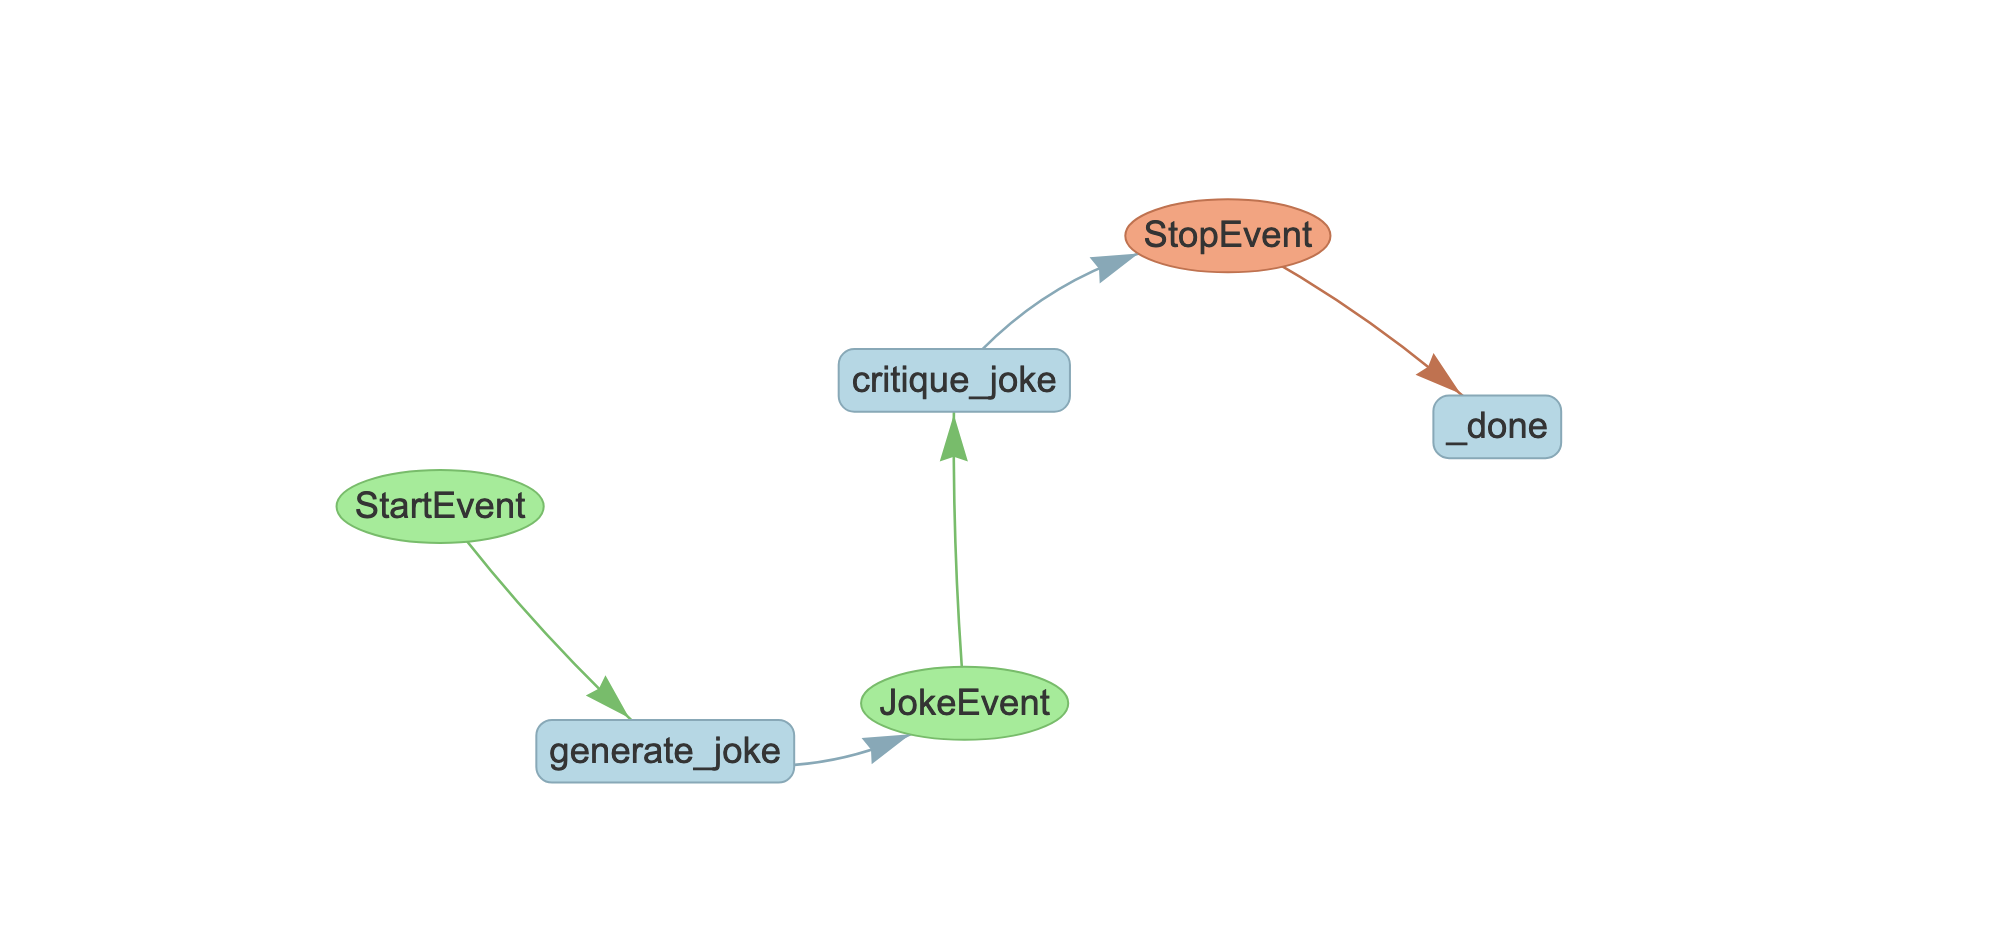